CODE TO BEAUTIFY REGULAR SHAPES AND FIND THE LINE OF SYMMETRIES IN THE REGULAR AS WELL AS THE IRREGULAR SHAPES (GIVEN THAT THE SHAPES HAVE SEPERATE CONTOUR ID'S)

This code works perfectly for the following testcases:
- isolated.csv
- occlusion1.csv

Since all have differentiated contour IDs.

This code also overcomes minor occlusion as seen in occlusion1.csv

Enter the path for the new shape CSV file: /content/occlusion1.csv
Best fitting shape: ellipse with score: 9.280938218199545
Best fitting shape: square with score: 17.172064148490218
Best fitting shape: circle with score: 0


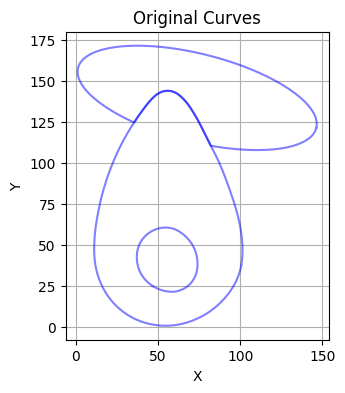

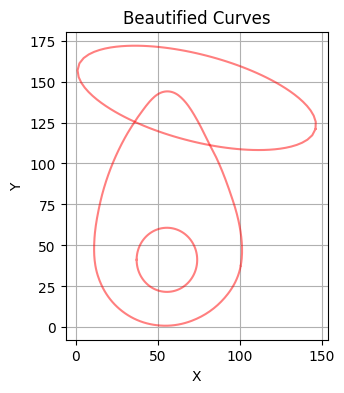


Symmetry Information Table for Regular Shapes:
+---------+-----------------------------------------------------------------------+
| Shape   | Symmetry Information                                                  |
+=========+=======================================================================+
| ellipse | 2 lines of reflectional symmetry, 2 rotational symmetries (180° each) |
+---------+-----------------------------------------------------------------------+
| circle  | Radial Symmetry                                                       |
+---------+-----------------------------------------------------------------------+

Symmetry Check Results for Irregular Shapes:
+----+----------------------+------------------------------+
|    |   Irregular Shape ID |   Number of Symmetries (LOS) |
+====+======================+==============================+
|  0 |                    1 |                            1 |
+----+----------------------+------------------------------+


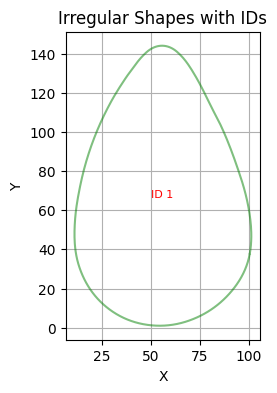

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from tabulate import tabulate
import pandas as pd
from scipy.spatial.distance import cdist

NUM_UNIFORM_POINTS = 100

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            if XY.shape[0] > 1:  # Ensure at least two points for interpolation
                XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def uniform_sampling(points, num_samples):
    if len(points) < 2:
        return points  # Not enough points to interpolate
    cumulative_dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    cumulative_dist = np.insert(cumulative_dist, 0, 0)  # Add the starting point
    try:
        distance_fn = interp1d(cumulative_dist, points, axis=0, kind='linear')
        uniform_dist = np.linspace(0, cumulative_dist[-1], num_samples)
        return distance_fn(uniform_dist)
    except ValueError as e:
        print(f"Interpolation error: {e}")
        return points

def clean_data(points):
    """Ensure there are no NaN or infinite values."""
    points = np.nan_to_num(points, nan=0.0, posinf=0.0, neginf=0.0)
    return points

def normalize_shape(points, num_points=NUM_UNIFORM_POINTS):
    if len(points) == 0:
        return np.zeros((num_points, 2))
    points = points - np.mean(points, axis=0)
    scale = np.sqrt(np.sum(points**2, axis=1)).max()
    if scale == 0:
        return np.zeros((num_points, 2))
    points /= scale
    points = clean_data(points)
    return uniform_sampling(points, num_points)

def process_multiple_shapes(shape_files):
    all_shapes = []
    for csv_path, label in shape_files:
        paths_XYs = read_csv(csv_path)
        for path in paths_XYs:
            for XY in path:
                key_points = normalize_shape(XY)
                all_shapes.append((key_points, label))
    return all_shapes

def hungarian_matching(input_points, reference_points):
    cost_matrix = np.linalg.norm(input_points[:, np.newaxis] - reference_points, axis=2)
    cost_matrix = clean_data(cost_matrix)
    if np.any(np.isnan(cost_matrix)) or np.any(np.isinf(cost_matrix)):
        raise ValueError("Cost matrix contains NaN or infinite values.")
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return cost_matrix[row_ind, col_ind].sum()

def internal_angles(points):
    angles = []
    for i in range(len(points)):
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[(i + 1) % len(points)]
        ba = p1 - p2
        bc = p3 - p2
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angles.append(np.degrees(angle))
    return angles

def classify_shape(input_points, reference_shapes):
    best_fit_label = None
    best_score = np.inf
    best_fit_shape = None

    for ref_points, label in reference_shapes:
        try:
            score = hungarian_matching(input_points, ref_points)
        except ValueError as e:
            print(f"Skipping due to error: {e}")
            continue

        if score < best_score:
            best_score = score
            best_fit_label = label
            best_fit_shape = ref_points

    # Apply angle constraint only for polygons pentagon or larger
    if best_fit_label in ['pentagon', 'hexagon', 'heptagon', 'octagon','nonagon','decagon']:
        angles = internal_angles(input_points)
        max_angle = max(angles) if angles else 0

        if max_angle > 170 or len(angles) < 5:  # Consider it a circle if angles are too large or not enough vertices
            best_fit_label = 'circle'
            best_fit_shape = [shape for shape, label in reference_shapes if label == 'circle'][0]
            best_score = 0  # Reset score since we're overriding the classification


    if best_fit_label in ['hexagon', 'heptagon', 'octagon','nonagon','decagon'] and best_score > 3:
        best_fit_label = 'circle'
        best_fit_shape = [shape for shape, label in reference_shapes if label == 'circle'][0]
        best_score = 0  # Reset score since we're overriding the classification


    return best_fit_label, best_score, best_fit_shape

def align_with_major_axis(points):
    pca = PCA(n_components=2)
    pca.fit(points)
    return pca.transform(points), pca

def scale_and_align_shape(reference_shape, original_shape, shape_label):
    if shape_label in ['rectangle', 'ellipse', 'line', 'triangle']:
        # Align both reference and original shapes with their major axes
        aligned_reference_shape, pca_reference = align_with_major_axis(reference_shape)
        aligned_original_shape, pca_original = align_with_major_axis(original_shape)

        # Compute the bounding box for the aligned original shape
        min_x, min_y = aligned_original_shape.min(axis=0)
        max_x, max_y = aligned_original_shape.max(axis=0)

        # Compute the bounding box dimensions
        bbox_width = max_x - min_x
        bbox_height = max_y - min_y

        # Determine the scaling factors for the reference shape
        ref_min_x, ref_min_y = aligned_reference_shape.min(axis=0)
        ref_max_x, ref_max_y = aligned_reference_shape.max(axis=0)
        ref_width = ref_max_x - ref_min_x
        ref_height = ref_max_y - ref_min_y

        # Avoid division by zero
        if ref_width == 0 or ref_height == 0:
            return original_shape, pca_original

        scale_x = bbox_width / ref_width
        scale_y = bbox_height / ref_height

        # Scale the reference shape to fit the aligned original shape's bounding box
        scaled_shape = aligned_reference_shape * [scale_x, scale_y]

        # Translate the scaled shape to align with the aligned original shape's bounding box
        aligned_shape = scaled_shape + [min_x - ref_min_x * scale_x, min_y - ref_min_y * scale_y]

        # Rotate aligned shape back to original orientation using the original shape's PCA
        aligned_shape = pca_original.inverse_transform(aligned_shape)

        return aligned_shape, pca_original
    else:
        # Simple scaling and translation for non-rectangles and non-ellipses
        # Compute the bounding box for the original shape
        min_x, min_y = original_shape.min(axis=0)
        max_x, max_y = original_shape.max(axis=0)

        # Compute the bounding box dimensions
        bbox_width = max_x - min_x
        bbox_height = max_y - min_y

        # Determine the scaling factors for the reference shape
        ref_min_x, ref_min_y = reference_shape.min(axis=0)
        ref_max_x, ref_max_y = reference_shape.max(axis=0)
        ref_width = ref_max_x - ref_min_x
        ref_height = ref_max_y - ref_min_y

        # Avoid division by zero
        if ref_width == 0 or ref_height == 0:
            return original_shape

        scale_x = bbox_width / ref_width
        scale_y = bbox_height / ref_height

        # Scale the reference shape to fit the original shape's bounding box
        scaled_shape = reference_shape * [scale_x, scale_y]

        # Translate the scaled shape to align with the original shape's bounding box
        aligned_shape = scaled_shape + [min_x - ref_min_x * scale_x, min_y - ref_min_y * scale_y]

        return aligned_shape, None

def draw_bounding_box(ax, pca, points, color='r'):
    if pca is not None:
        # Transform the points to PCA space
        aligned_points = pca.transform(points)

        # Compute the bounding box in PCA space
        min_x, min_y = aligned_points.min(axis=0)
        max_x, max_y = aligned_points.max(axis=0)

        # Define the corners of the bounding box
        bbox_points = np.array([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y], [min_x, min_y]])

        # Transform the bounding box points back to the original space
        bbox_points = pca.inverse_transform(bbox_points)

        # Plot the bounding box
        ax.plot(bbox_points[:, 0], bbox_points[:, 1], color=color, linestyle='--')

def add_points_to_contour(contour, min_points=10):
    if len(contour) >= min_points:
        return contour
    points_needed = min_points - len(contour)
    extended_contour = []
    for i in range(len(contour)):
        extended_contour.append(contour[i])
        if i < len(contour) - 1:
            next_point = contour[i + 1]
        else:
            next_point = contour[0]
        distance = np.linalg.norm(contour[i] - next_point)
        num_new_points = points_needed // len(contour) + (1 if points_needed % len(contour) > i else 0)
        for j in range(1, num_new_points + 1):
            new_point = contour[i] + (next_point - contour[i]) * (j / (num_new_points + 1))
            extended_contour.append(new_point)
        points_needed -= num_new_points
    return np.array(extended_contour)


# Define the reference shapes (already known and processed)
shape_files = [
    ('/content/densified_square.csv', 'square'),
    ('/content/densified_star.csv', 'star'),
    ('/content/circle.csv', 'circle'),
    ('/content/ellipse1.csv', 'ellipse'),
    ('/content/densified_pen.csv', 'pentagon'),
    ('/content/densified_hex.csv', 'hexagon'),
    ('/content/densified_hept.csv', 'heptagon'),
    ('/content/densified_oct.csv', 'octagon'),
    ('/content/densified_nona.csv', 'nonagon'),
    ('/content/densified_deca.csv', 'decagon'),
    ('/content/densified_rec.csv', 'rectangle'),
    ('/content/densified_triangle.csv', 'triangle'),
    ('/content/densified_line.csv', 'line')
]

# Define the symmetry types for known shapes
symmetry_info = {
    'square': '4 lines of reflectional symmetry, 4 rotational symmetries (90° each)',
    'star': '5 lines of reflectional symmetry, 5 rotational symmetries (72° each)',
    'circle': 'Radial Symmetry',
    'ellipse': '2 lines of reflectional symmetry, 2 rotational symmetries (180° each)',
    'rectangle': '2 lines of reflectional symmetry, 2 rotational symmetries (180° each)',
    'pentagon': '5 lines of reflectional symmetry, 5 rotational symmetries (72° each)',
    'hexagon': '6 lines of reflectional symmetry, 6 rotational symmetries (60° each)',
    'heptagon': '7 lines of reflectional symmetry, 7 rotational symmetries (51.43° each)',
    'octagon': '8 lines of reflectional symmetry, 8 rotational symmetries (45° each)',
    'nonagon': '9 lines of reflectional symmetry, 9 rotational symmetries (40° each)',
    'decagon': '10 lines of reflectional symmetry, 10 rotational symmetries (36° each)',
    'triangle': '3 lines of reflectional symmetry, 3 rotational symmetries (120° each)',
    'line': '1 line of reflectional symmetry, 1 rotational symmetry (0°)'
}

reference_shapes = process_multiple_shapes(shape_files)

# Prompt user for the new shape CSV file path
new_shape_path = input("Enter the path for the new shape CSV file: ")
new_shape_paths_XYs = read_csv(new_shape_path)

# Prepare lists to store original and replaced shapes for plotting
original_shapes = []
replaced_shapes = []
bounding_boxes = []
symmetry_table = []
irregular_shapes = []  # List to store irregular shapes

# Classify and store each shape for separate plotting
for path in new_shape_paths_XYs:
    for XY in path:
        if len(XY) < 10:
            XY = add_points_to_contour(XY)  # Add points to contour if fewer than 10
        normalized_input_points = normalize_shape(XY)
        best_label, best_score, best_fit_shape = classify_shape(normalized_input_points, reference_shapes)
        if best_fit_shape is None:
            continue  # Skip if no valid classification was found
        print(f'Best fitting shape: {best_label} with score: {best_score}')

        if best_score < 10:
            # Add symmetry info to table
            symmetry_table.append([best_label, symmetry_info[best_label]])

            # Scale and align the best fitting reference shape to the original shape's position
            transformed_shape, pca = scale_and_align_shape(best_fit_shape, XY, best_label)
            bounding_boxes.append((transformed_shape, pca))
        else:
            # If score is greater than 10, keep the original shape and append to irregular_shapes
            transformed_shape = XY
            irregular_shapes.append(XY)  # Append the path ID and contour ID

        # Store original and transformed shapes
        original_shapes.append(XY)
        replaced_shapes.append(transformed_shape)


def check_symmetry(irregular_shapes, extension_factor=3, symmetry_threshold=200):
    results = []
    for idx, shape in enumerate(irregular_shapes):
        if shape.shape[0] < 2:
            continue  # Skip shapes that do not have enough points for PCA

        # Compute the centroid
        centroid = np.mean(shape, axis=0)

        # Perform PCA to find the major and minor axes
        pca = PCA(n_components=2)
        pca.fit(shape)
        components = pca.components_
        explained_variance = pca.explained_variance_

        # Flip points on the right side of the major axis
        major_axis = components[0]
        projection_major = np.dot(shape - centroid, major_axis)
        left_side_major = shape[projection_major <= 0]
        right_side_major = shape[projection_major > 0]
        right_side_flipped_major = right_side_major - 2 * np.outer(projection_major[projection_major > 0], major_axis)

        # Calculate matching score using Hungarian algorithm for the major axis
        cost_matrix_major = cdist(left_side_major, right_side_flipped_major, metric='euclidean')
        row_ind_major, col_ind_major = linear_sum_assignment(cost_matrix_major)
        hungarian_score_major = cost_matrix_major[row_ind_major, col_ind_major].sum()

        # Determine symmetry for the major axis
        symmetry_major = 1 if hungarian_score_major < symmetry_threshold else 0

        # Flip points on the right side of the minor axis
        minor_axis = components[1]
        projection_minor = np.dot(shape - centroid, minor_axis)
        left_side_minor = shape[projection_minor <= 0]
        right_side_minor = shape[projection_minor > 0]
        right_side_flipped_minor = right_side_minor - 2 * np.outer(projection_minor[projection_minor > 0], minor_axis)

        # Calculate matching score using Hungarian algorithm for the minor axis
        cost_matrix_minor = cdist(left_side_minor, right_side_flipped_minor, metric='euclidean')
        row_ind_minor, col_ind_minor = linear_sum_assignment(cost_matrix_minor)
        hungarian_score_minor = cost_matrix_minor[row_ind_minor, col_ind_minor].sum()

        # Determine symmetry for the minor axis
        symmetry_minor = 1 if hungarian_score_minor < symmetry_threshold else 0

        # Add results to the list
        results.append([idx + 1, symmetry_major + symmetry_minor])

    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=['Irregular Shape ID', 'Number of Symmetries (LOS)'])

    return results_df

# Check symmetry for irregular shapes
symmetry_results_df = check_symmetry(irregular_shapes)


# Plotting original shapes with bounding boxes
fig, ax = plt.subplots(figsize=(6, 4))
for XY in original_shapes:
    ax.plot(XY[:, 0], XY[:, 1], 'b-', alpha=0.5)

# for transformed_shape, pca in bounding_boxes:
#     draw_bounding_box(ax, pca, transformed_shape, color='r')

plt.title('Original Curves')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Plotting replaced shapes with bounding boxes
fig, ax = plt.subplots(figsize=(6, 4))
for transformed_shape in replaced_shapes:
    ax.plot(transformed_shape[:, 0], transformed_shape[:, 1], 'r-', alpha=0.5)

# for transformed_shape, pca in bounding_boxes:
#     draw_bounding_box(ax, pca, transformed_shape, color='r')

plt.title('Beautified Curves')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



# Symmetry check function
# Display symmetry table for regular shapes
print("\nSymmetry Information Table for Regular Shapes:")
print(tabulate(symmetry_table, headers=["Shape", "Symmetry Information"], tablefmt="grid"))

# Check symmetry for irregular shapes
symmetry_results_df = check_symmetry(irregular_shapes)

# Display symmetry table for irregular shapes
print("\nSymmetry Check Results for Irregular Shapes:")
print(tabulate(symmetry_results_df, headers=['Irregular Shape ID', 'Number of Symmetries (LOS)'], tablefmt="grid"))

# Plotting irregular shapes with shape IDs as labels
fig, ax = plt.subplots(figsize=(6, 4))
for idx, XY in enumerate(irregular_shapes):
    ax.plot(XY[:, 0], XY[:, 1], 'g-', alpha=0.5)
    # Label the shape with its ID
    centroid = np.mean(XY, axis=0)
    ax.text(centroid[0], centroid[1], f'ID {idx + 1}', color='red', fontsize=8, ha='center')

plt.title('Irregular Shapes with IDs')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()




HERE WE HAVE ATTEMPTED TO MERGE THE FRAGMENTED CONTOURS AND SAVED IT INTO ANOTHER CSV FILE, WHICH WHEN RUN ON THE ABOVE CODE WILL GIVE THE CORRECT RESULT.

This code works correctly for:
- frag0.csv

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import csv

# Function to read CSV and group polylines
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            if XY.shape[0] > 1:  # Ensure at least two points for interpolation
                XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to calculate the centroid of all points
def calculate_centroid(polylines):
    all_points = np.vstack([point for polyline_group in polylines for polyline in polyline_group for point in polyline])
    centroid = np.mean(all_points, axis=0)
    return centroid

# Function to sort polylines based on distance from centroid
def sort_polylines_by_distance(polylines, centroid):
    polyline_distances = []
    for polyline_group in polylines:
        for polyline in polyline_group:
            distance = euclidean(polyline[0], centroid)
            polyline_distances.append((distance, polyline))

    polyline_distances.sort(reverse=True, key=lambda x: x[0])
    sorted_polylines = [polyline for _, polyline in polyline_distances]
    return sorted_polylines

# Function to join polylines using splines
def spline_join(sorted_polylines, max_distance=0.5):
    visited = set()
    merged_polylines = []

    def find_next_polyline(start_point):
        for i, polyline in enumerate(sorted_polylines):
            if i not in visited and euclidean(start_point, polyline[0]) <= max_distance:
                visited.add(i)
                return polyline, i
        return None, None

    while len(visited) < len(sorted_polylines):
        # Find the farthest unvisited point
        for i, polyline in enumerate(sorted_polylines):
            if i not in visited:
                visited.add(i)
                current_polyline = list(polyline)
                break

        start_point = current_polyline[0]

        while True:
            next_polyline, index = find_next_polyline(current_polyline[-1])
            if next_polyline is not None:
                current_polyline.extend(next_polyline)
            else:
                break

        # Close the loop if possible
        if euclidean(current_polyline[-1], start_point) <= max_distance:
            current_polyline.append(start_point)

        merged_polylines.append(np.array(current_polyline))

    return merged_polylines

# Function to save the merged polylines to a CSV file
def save_merged_polylines_to_csv(merged_polylines, output_csv_path):
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Contour ID 1", "Contour ID 2", "X", "Y"])
        for i, polyline in enumerate(merged_polylines):
            for point in polyline:
                writer.writerow([i + 1, i + 1, point[0], point[1]])

# Function to plot the merged polylines
def plot_merged_polylines(merged_polylines, title="Merged Polylines"):
    plt.figure(figsize=(10, 8))
    for polyline in merged_polylines:
        plt.plot(polyline[:, 0], polyline[:, 1], marker='o', linestyle='-', label='Merged Polyline')
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Ask the user for the input CSV file path
csv_path = input("Enter the path to the input CSV file: ")

# Load and process the CSV file
path_XYs = read_csv(csv_path)

# Calculate the centroid of all points
centroid = calculate_centroid(path_XYs)

# Sort the polylines by distance from the centroid, starting with the farthest
sorted_polylines = sort_polylines_by_distance(path_XYs, centroid)

# Join the sorted polylines using splines
merged_polylines = spline_join(sorted_polylines, max_distance=0.5)

# Save the merged polylines to a CSV file
output_csv_path = 'merged_polylines.csv'
save_merged_polylines_to_csv(merged_polylines, output_csv_path)

# Optional: Visualize the merged polylines
# plot_merged_polylines(merged_polylines, title="Spline Joined Polylines")

print(f"Merged polylines have been saved to {output_csv_path}")


Enter the path to the input CSV file: /content/frag0.csv
Merged polylines have been saved to merged_polylines.csv


From the above code, a file will be saved "merged_polylines.csv" to the content.

This file when run on our first code (which is useful when differentiated contour IDs are given) will give us the desired result.

Enter the path for the new shape CSV file: /content/merged_polylines.csv
Best fitting shape: square with score: 4.1784491334169385
Best fitting shape: circle with score: 0
Best fitting shape: star with score: 28.14681403536236
Best fitting shape: star with score: 29.864218968230187


<ipython-input-38-05e0ca632637>:80: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


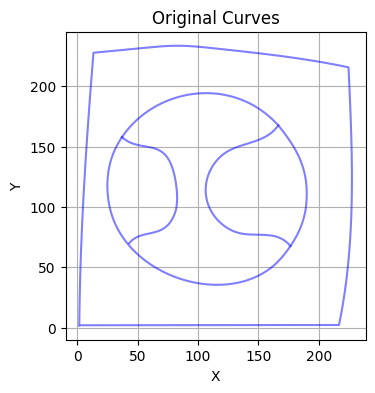

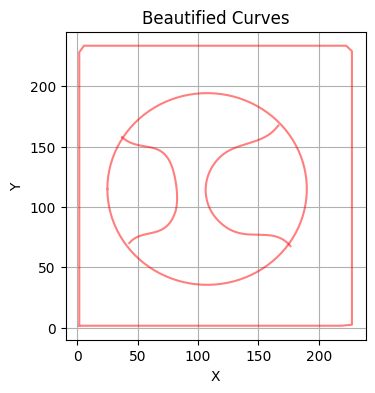


Symmetry Information Table for Regular Shapes:
+---------+----------------------------------------------------------------------+
| Shape   | Symmetry Information                                                 |
+=========+======================================================================+
| square  | 4 lines of reflectional symmetry, 4 rotational symmetries (90° each) |
+---------+----------------------------------------------------------------------+
| circle  | Radial Symmetry                                                      |
+---------+----------------------------------------------------------------------+

Symmetry Check Results for Irregular Shapes:
+----+----------------------+------------------------------+
|    |   Irregular Shape ID |   Number of Symmetries (LOS) |
+====+======================+==============================+
|  0 |                    1 |                            1 |
+----+----------------------+------------------------------+
|  1 |              

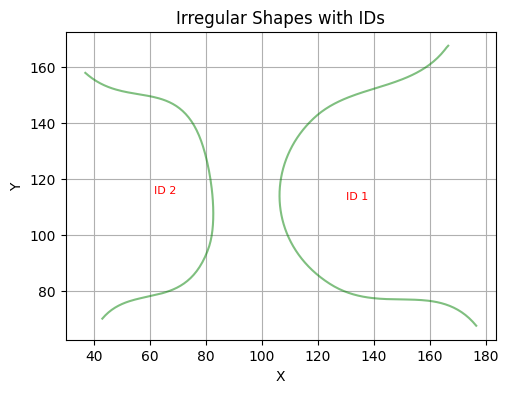

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from tabulate import tabulate
import pandas as pd
from scipy.spatial.distance import cdist

NUM_UNIFORM_POINTS = 100

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            if XY.shape[0] > 1:  # Ensure at least two points for interpolation
                XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def uniform_sampling(points, num_samples):
    if len(points) < 2:
        return points  # Not enough points to interpolate
    cumulative_dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    cumulative_dist = np.insert(cumulative_dist, 0, 0)  # Add the starting point
    try:
        distance_fn = interp1d(cumulative_dist, points, axis=0, kind='linear')
        uniform_dist = np.linspace(0, cumulative_dist[-1], num_samples)
        return distance_fn(uniform_dist)
    except ValueError as e:
        print(f"Interpolation error: {e}")
        return points

def clean_data(points):
    """Ensure there are no NaN or infinite values."""
    points = np.nan_to_num(points, nan=0.0, posinf=0.0, neginf=0.0)
    return points

def normalize_shape(points, num_points=NUM_UNIFORM_POINTS):
    if len(points) == 0:
        return np.zeros((num_points, 2))
    points = points - np.mean(points, axis=0)
    scale = np.sqrt(np.sum(points**2, axis=1)).max()
    if scale == 0:
        return np.zeros((num_points, 2))
    points /= scale
    points = clean_data(points)
    return uniform_sampling(points, num_points)

def process_multiple_shapes(shape_files):
    all_shapes = []
    for csv_path, label in shape_files:
        paths_XYs = read_csv(csv_path)
        for path in paths_XYs:
            for XY in path:
                key_points = normalize_shape(XY)
                all_shapes.append((key_points, label))
    return all_shapes

def hungarian_matching(input_points, reference_points):
    cost_matrix = np.linalg.norm(input_points[:, np.newaxis] - reference_points, axis=2)
    cost_matrix = clean_data(cost_matrix)
    if np.any(np.isnan(cost_matrix)) or np.any(np.isinf(cost_matrix)):
        raise ValueError("Cost matrix contains NaN or infinite values.")
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return cost_matrix[row_ind, col_ind].sum()

def internal_angles(points):
    angles = []
    for i in range(len(points)):
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[(i + 1) % len(points)]
        ba = p1 - p2
        bc = p3 - p2
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angles.append(np.degrees(angle))
    return angles

def classify_shape(input_points, reference_shapes):
    best_fit_label = None
    best_score = np.inf
    best_fit_shape = None

    for ref_points, label in reference_shapes:
        try:
            score = hungarian_matching(input_points, ref_points)
        except ValueError as e:
            print(f"Skipping due to error: {e}")
            continue

        if score < best_score:
            best_score = score
            best_fit_label = label
            best_fit_shape = ref_points

    # Apply angle constraint only for polygons pentagon or larger
    if best_fit_label in ['pentagon', 'hexagon', 'heptagon', 'octagon','nonagon','decagon']:
        angles = internal_angles(input_points)
        max_angle = max(angles) if angles else 0

        if max_angle > 170 or len(angles) < 5:  # Consider it a circle if angles are too large or not enough vertices
            best_fit_label = 'circle'
            best_fit_shape = [shape for shape, label in reference_shapes if label == 'circle'][0]
            best_score = 0  # Reset score since we're overriding the classification


    if best_fit_label in ['hexagon', 'heptagon', 'octagon','nonagon','decagon'] and best_score > 3:
        best_fit_label = 'circle'
        best_fit_shape = [shape for shape, label in reference_shapes if label == 'circle'][0]
        best_score = 0  # Reset score since we're overriding the classification



    return best_fit_label, best_score, best_fit_shape


def align_with_major_axis(points):
    pca = PCA(n_components=2)
    pca.fit(points)
    return pca.transform(points), pca

def scale_and_align_shape(reference_shape, original_shape, shape_label):
    if shape_label in ['rectangle', 'ellipse1', 'line', 'triangle']:
        # Align both reference and original shapes with their major axes
        aligned_reference_shape, pca_reference = align_with_major_axis(reference_shape)
        aligned_original_shape, pca_original = align_with_major_axis(original_shape)

        # Compute the bounding box for the aligned original shape
        min_x, min_y = aligned_original_shape.min(axis=0)
        max_x, max_y = aligned_original_shape.max(axis=0)

        # Compute the bounding box dimensions
        bbox_width = max_x - min_x
        bbox_height = max_y - min_y

        # Determine the scaling factors for the reference shape
        ref_min_x, ref_min_y = aligned_reference_shape.min(axis=0)
        ref_max_x, ref_max_y = aligned_reference_shape.max(axis=0)
        ref_width = ref_max_x - ref_min_x
        ref_height = ref_max_y - ref_min_y

        # Avoid division by zero
        if ref_width == 0 or ref_height == 0:
            return original_shape, pca_original

        scale_x = bbox_width / ref_width
        scale_y = bbox_height / ref_height

        # Scale the reference shape to fit the aligned original shape's bounding box
        scaled_shape = aligned_reference_shape * [scale_x, scale_y]

        # Translate the scaled shape to align with the aligned original shape's bounding box
        aligned_shape = scaled_shape + [min_x - ref_min_x * scale_x, min_y - ref_min_y * scale_y]

        # Rotate aligned shape back to original orientation using the original shape's PCA
        aligned_shape = pca_original.inverse_transform(aligned_shape)

        return aligned_shape, pca_original
    else:
        # Simple scaling and translation for non-rectangles and non-ellipses
        # Compute the bounding box for the original shape
        min_x, min_y = original_shape.min(axis=0)
        max_x, max_y = original_shape.max(axis=0)

        # Compute the bounding box dimensions
        bbox_width = max_x - min_x
        bbox_height = max_y - min_y

        # Determine the scaling factors for the reference shape
        ref_min_x, ref_min_y = reference_shape.min(axis=0)
        ref_max_x, ref_max_y = reference_shape.max(axis=0)
        ref_width = ref_max_x - ref_min_x
        ref_height = ref_max_y - ref_min_y

        # Avoid division by zero
        if ref_width == 0 or ref_height == 0:
            return original_shape

        scale_x = bbox_width / ref_width
        scale_y = bbox_height / ref_height

        # Scale the reference shape to fit the original shape's bounding box
        scaled_shape = reference_shape * [scale_x, scale_y]

        # Translate the scaled shape to align with the original shape's bounding box
        aligned_shape = scaled_shape + [min_x - ref_min_x * scale_x, min_y - ref_min_y * scale_y]

        return aligned_shape, None

def draw_bounding_box(ax, pca, points, color='r'):
    if pca is not None:
        # Transform the points to PCA space
        aligned_points = pca.transform(points)

        # Compute the bounding box in PCA space
        min_x, min_y = aligned_points.min(axis=0)
        max_x, max_y = aligned_points.max(axis=0)

        # Define the corners of the bounding box
        bbox_points = np.array([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y], [min_x, min_y]])

        # Transform the bounding box points back to the original space
        bbox_points = pca.inverse_transform(bbox_points)

        # Plot the bounding box
        ax.plot(bbox_points[:, 0], bbox_points[:, 1], color=color, linestyle='--')

def add_points_to_contour(contour, min_points=10):
    if len(contour) >= min_points:
        return contour
    points_needed = min_points - len(contour)
    extended_contour = []
    for i in range(len(contour)):
        extended_contour.append(contour[i])
        if i < len(contour) - 1:
            next_point = contour[i + 1]
        else:
            next_point = contour[0]
        distance = np.linalg.norm(contour[i] - next_point)
        num_new_points = points_needed // len(contour) + (1 if points_needed % len(contour) > i else 0)
        for j in range(1, num_new_points + 1):
            new_point = contour[i] + (next_point - contour[i]) * (j / (num_new_points + 1))
            extended_contour.append(new_point)
        points_needed -= num_new_points
    return np.array(extended_contour)

# Define the reference shapes (already known and processed)
shape_files = [
    ('/content/densified_square.csv', 'square'),
    ('/content/densified_star.csv', 'star'),
    ('/content/circle.csv', 'circle'),
    ('/content/ellipse1.csv', 'ellipse'),
    ('/content/densified_pen.csv', 'pentagon'),
    ('/content/densified_hex.csv', 'hexagon'),
    ('/content/densified_hept.csv', 'heptagon'),
    ('/content/densified_oct.csv', 'octagon'),
    ('/content/densified_nona.csv', 'nonagon'),
    ('/content/densified_deca.csv', 'decagon'),
    ('/content/densified_rec.csv', 'rectangle'),
    ('/content/densified_triangle.csv', 'triangle'),
    ('/content/densified_line.csv', 'line')
]

# Define the symmetry types for known shapes
symmetry_info = {
    'square': '4 lines of reflectional symmetry, 4 rotational symmetries (90° each)',
    'star': '5 lines of reflectional symmetry, 5 rotational symmetries (72° each)',
    'circle': 'Radial Symmetry',
    'ellipse': '2 lines of reflectional symmetry, 2 rotational symmetries (180° each)',
    'rectangle': '2 lines of reflectional symmetry, 2 rotational symmetries (180° each)',
    'pentagon': '5 lines of reflectional symmetry, 5 rotational symmetries (72° each)',
    'hexagon': '6 lines of reflectional symmetry, 6 rotational symmetries (60° each)',
    'heptagon': '7 lines of reflectional symmetry, 7 rotational symmetries (51.43° each)',
    'octagon': '8 lines of reflectional symmetry, 8 rotational symmetries (45° each)',
    'nonagon': '9 lines of reflectional symmetry, 9 rotational symmetries (40° each)',
    'decagon': '10 lines of reflectional symmetry, 10 rotational symmetries (36° each)',
    'triangle': '3 lines of reflectional symmetry, 3 rotational symmetries (120° each)',
    'line': '1 line of reflectional symmetry, 1 rotational symmetry (0°)'
}

reference_shapes = process_multiple_shapes(shape_files)

# Prompt user for the new shape CSV file path
new_shape_path = input("Enter the path for the new shape CSV file: ")
new_shape_paths_XYs = read_csv(new_shape_path)

# Prepare lists to store original and replaced shapes for plotting
original_shapes = []
replaced_shapes = []
bounding_boxes = []
symmetry_table = []
irregular_shapes = []  # List to store irregular shapes

# Classify and store each shape for separate plotting
for path in new_shape_paths_XYs:
    for XY in path:
        if len(XY) < 10:
            XY = add_points_to_contour(XY)  # Add points to contour if fewer than 10
        normalized_input_points = normalize_shape(XY)
        best_label, best_score, best_fit_shape = classify_shape(normalized_input_points, reference_shapes)
        if best_fit_shape is None:
            continue  # Skip if no valid classification was found
        print(f'Best fitting shape: {best_label} with score: {best_score}')

        if best_score < 10:
            # Add symmetry info to table
            symmetry_table.append([best_label, symmetry_info[best_label]])

            # Scale and align the best fitting reference shape to the original shape's position
            transformed_shape, pca = scale_and_align_shape(best_fit_shape, XY, best_label)
            bounding_boxes.append((transformed_shape, pca))
        else:
            # If score is greater than 10, keep the original shape and append to irregular_shapes
            transformed_shape = XY
            irregular_shapes.append(XY)  # Append the path ID and contour ID

        # Store original and transformed shapes
        original_shapes.append(XY)
        replaced_shapes.append(transformed_shape)



def check_symmetry(irregular_shapes, extension_factor=3, symmetry_threshold=200):
    results = []
    for idx, shape in enumerate(irregular_shapes):
        if shape.shape[0] < 2:
            continue  # Skip shapes that do not have enough points for PCA

        # Compute the centroid
        centroid = np.mean(shape, axis=0)

        # Perform PCA to find the major and minor axes
        pca = PCA(n_components=2)
        pca.fit(shape)
        components = pca.components_
        explained_variance = pca.explained_variance_

        # Flip points on the right side of the major axis
        major_axis = components[0]
        projection_major = np.dot(shape - centroid, major_axis)
        left_side_major = shape[projection_major <= 0]
        right_side_major = shape[projection_major > 0]
        right_side_flipped_major = right_side_major - 2 * np.outer(projection_major[projection_major > 0], major_axis)

        # Calculate matching score using Hungarian algorithm for the major axis
        cost_matrix_major = cdist(left_side_major, right_side_flipped_major, metric='euclidean')
        row_ind_major, col_ind_major = linear_sum_assignment(cost_matrix_major)
        hungarian_score_major = cost_matrix_major[row_ind_major, col_ind_major].sum()

        # Determine symmetry for the major axis
        symmetry_major = 1 if hungarian_score_major < symmetry_threshold else 0

        # Flip points on the right side of the minor axis
        minor_axis = components[1]
        projection_minor = np.dot(shape - centroid, minor_axis)
        left_side_minor = shape[projection_minor <= 0]
        right_side_minor = shape[projection_minor > 0]
        right_side_flipped_minor = right_side_minor - 2 * np.outer(projection_minor[projection_minor > 0], minor_axis)

        # Calculate matching score using Hungarian algorithm for the minor axis
        cost_matrix_minor = cdist(left_side_minor, right_side_flipped_minor, metric='euclidean')
        row_ind_minor, col_ind_minor = linear_sum_assignment(cost_matrix_minor)
        hungarian_score_minor = cost_matrix_minor[row_ind_minor, col_ind_minor].sum()

        # Determine symmetry for the minor axis
        symmetry_minor = 1 if hungarian_score_minor < symmetry_threshold else 0

        # Add results to the list
        results.append([idx + 1, symmetry_major + symmetry_minor])

    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=['Irregular Shape ID', 'Number of Symmetries (LOS)'])

    return results_df

# Check symmetry for irregular shapes
symmetry_results_df = check_symmetry(irregular_shapes)


# Plotting original shapes with bounding boxes
fig, ax = plt.subplots(figsize=(6, 4))
for XY in original_shapes:
    ax.plot(XY[:, 0], XY[:, 1], 'b-', alpha=0.5)

# for transformed_shape, pca in bounding_boxes:
#     draw_bounding_box(ax, pca, transformed_shape, color='r')

plt.title('Original Curves')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Plotting replaced shapes with bounding boxes
fig, ax = plt.subplots(figsize=(6, 4))
for transformed_shape in replaced_shapes:
    ax.plot(transformed_shape[:, 0], transformed_shape[:, 1], 'r-', alpha=0.5)

# for transformed_shape, pca in bounding_boxes:
#     draw_bounding_box(ax, pca, transformed_shape, color='r')

plt.title('Beautified Curves')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



# Symmetry check function
# Display symmetry table for regular shapes
print("\nSymmetry Information Table for Regular Shapes:")
print(tabulate(symmetry_table, headers=["Shape", "Symmetry Information"], tablefmt="grid"))

# Check symmetry for irregular shapes
symmetry_results_df = check_symmetry(irregular_shapes)

# Display symmetry table for irregular shapes
print("\nSymmetry Check Results for Irregular Shapes:")
print(tabulate(symmetry_results_df, headers=['Irregular Shape ID', 'Number of Symmetries (LOS)'], tablefmt="grid"))

# Plotting irregular shapes with shape IDs as labels
fig, ax = plt.subplots(figsize=(6, 4))
for idx, XY in enumerate(irregular_shapes):
    ax.plot(XY[:, 0], XY[:, 1], 'g-', alpha=0.5)
    # Label the shape with its ID
    centroid = np.mean(XY, axis=0)
    ax.text(centroid[0], centroid[1], f'ID {idx + 1}', color='red', fontsize=8, ha='center')

plt.title('Irregular Shapes with IDs')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


